In [29]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.manifold import TSNE
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import SMOTE
import string
from nltk import FreqDist
from nltk.corpus import stopwords


In [30]:
df = pd.read_csv('data/judge_1377884607_tweet_product_company.csv')
df.head(-7)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
8709,Diller says Google TV &quot;might be run over ...,Other Google product or service,Negative emotion
8710,Google says reports about launch of Circles so...,NaN,No emotion toward brand or product
8711,"Google says the future is all around you! (ie,...",NaN,No emotion toward brand or product
8712,"Google says the future is location, location, ...",NaN,No emotion toward brand or product


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [32]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [33]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [34]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [35]:
pos_neg = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

In [36]:
pos_neg = pos_neg[pos_neg['is_there_an_emotion_directed_at_a_brand_or_product'] != "No emotion toward brand or product"]

### Heavily imbalanced datset

In [37]:
pos_neg.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(normalize=True)

Positive emotion    0.840363
Negative emotion    0.159637
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

### More Data Cleaning

In [38]:
pos_neg = pos_neg.drop('emotion_in_tweet_is_directed_at', axis=1)
pos_neg = pos_neg.rename(columns={'tweet_text':'text', 'is_there_an_emotion_directed_at_a_brand_or_product':'target'})
pos_neg.head()

,text,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [39]:
def remove_ats_and_hashtags(text):
    entity_prefixes = ['@','#','�']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [40]:
pos_neg['text'] = pos_neg['text'].map(remove_ats_and_hashtags)

In [41]:
pos_neg.replace({'Negative emotion' : 0, 'Positive emotion' : 1}, inplace=True)

In [42]:
pos_neg['text'] = pos_neg['text'].str.lower()

In [43]:
pos_neg.head()

,text,target
0,i have a 3g iphone after 3 hrs tweeting at aus...,0
1,know about awesome ipad iphone app that you ll...,1
2,can not wait for 2 also they should sale them ...,1
3,i hope this year s festival isn t as crashy as...,0
4,great stuff on fri marissa mayer google tim o ...,1


In [44]:
X = pos_neg.drop(['target'], axis=1)
y = pos_neg['target']

In [45]:
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [46]:
y_train.value_counts(normalize=True)

1    0.840352
0    0.159648
Name: target, dtype: float64

### Exploring our Words

In [47]:
pos_neg['text_tokenized'] = pos_neg['text'].apply(word_tokenize)

In [48]:
pos_neg_freq_dist = FreqDist(pos_neg['text_tokenized'].explode())

In [49]:
def visualize_top_20(freq_dist, title):

    # Extract data for plotting
    top_20 = list(zip(*freq_dist.most_common(20)))
    tokens = top_20[0]
    counts = top_20[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
#     ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)

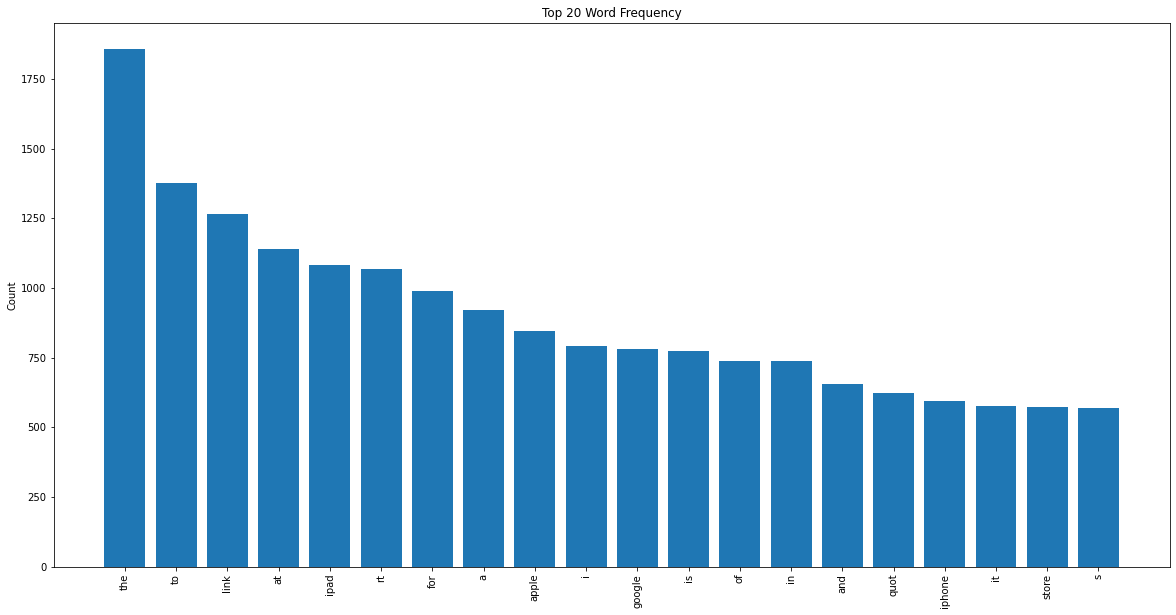

In [50]:
visualize_top_20(pos_neg_freq_dist, "Top 20 Word Frequency")

### Build a baseline

In [51]:
tfidf = TfidfVectorizer(max_features=20)

X_train_vectorized = tfidf.fit_transform(X_train['text'])

pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

/Users/patrick/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,and,app,apple,at,for,google,in,ipad,iphone,is,it,link,of,on,quot,rt,store,the,to,up
0,0.000000,0.0,0.000000,0.000000,0.473799,0.000000,0.522109,0.000000,0.546249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.452249,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.402497,0.000000,0.000000,0.532125,0.371240,0.000000,0.546399,0.000000,0.000000,0.000000,0.344192,0.000000,0.000000
2,0.311664,0.0,0.000000,0.000000,0.000000,0.288072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.799608,0.000000,0.000000,0.424862,0.000000,0.000000
3,0.296155,0.0,0.000000,0.000000,0.513751,0.000000,0.283067,0.236055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.201860,0.686845,0.000000
4,0.000000,0.0,0.000000,0.604820,0.653132,0.000000,0.000000,0.000000,0.376503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256626,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2726,0.474229,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.377992,0.000000,0.000000,0.000000,0.000000,0.463434,0.513132,0.000000,0.392623,0.000000,0.000000,0.000000,0.000000
2727,0.000000,0.0,0.319787,0.000000,0.306455,0.000000,0.337702,0.281616,0.000000,0.335119,0.000000,0.259746,0.000000,0.000000,0.000000,0.292517,0.368344,0.240822,0.000000,0.389179
2728,0.000000,0.0,0.000000,0.360166,0.777871,0.414466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.305637,0.000000,0.000000
2729,0.000000,0.0,0.000000,0.000000,0.000000,0.486320,0.000000,0.000000,0.000000,0.499048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.717248,0.000000,0.000000


In [52]:
smote = SMOTE(k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)

In [53]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

baseline_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_resampled, y_train_resampled)
baseline_cv

array([0.62636166, 0.65141612, 0.61873638, 0.63071895, 0.66557734])

In [54]:
print("Baseline:         ", baseline_cv.mean())

Baseline:          0.6385620915032679


### Remove Stopwords

In [ ]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
new_stops = ('quot', 'rt', 'i')
stopwords_list += list(new_stops)

In [ ]:
def remove_stopwords(token_list):
    """
    Given a list of tokens, return a list where the tokens
    that are also present in stopwords_list have been
    removed
    """
    stops_rmv_list = [token for token in token_list if token not in stopwords_list]
    return stops_rmv_list

In [ ]:
pattern = "([a-z]{2,})"
regex_tokenizer = RegexpTokenizer(pattern)

In [ ]:
X_train['text'] = [regex_tokenizer.tokenize(text) for text in X_train['text']]